In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize, differential_evolution
import time

def run_izhikevich_simulation(params, duration=3000*ms):
    """
    Ejecuta simulación del modelo Izhikevich con parámetros dados
    
    params: dict con parámetros a optimizar
    duration: duración de la simulación  
    
    Returns: dict con resultados del espectro
    """
    start_scope()
    np.random.seed(42)  # Para reproducibilidad
    defaultclock.dt = 0.01*ms  # Timestep más grande para mejor eficiencia
    
    N_exc = 800
    N_inh = 200
    N_total = N_exc + N_inh
    
    # Ecuaciones del modelo
    equations = '''
    dv/dt = (0.04*v**2 + 5*v + 140 - u + I_syn + I_thalamic)/ms : 1
    du/dt = a*(b*v - u)/ms : 1 
    I_syn : 1
    I_thalamic: 1
    a : 1
    b : 1  
    c : 1
    d : 1
    '''
    
    # Crear grupos neuronales
    exc_neurons = NeuronGroup(N_exc, equations, 
                              threshold='v >= 30',
                              reset='v = c; u += d',
                              method='euler')
    
    inh_neurons = NeuronGroup(N_inh, equations,
                              threshold='v >= 30', 
                              reset='v = c; u += d',
                              method='euler')
    
    # Input talámico parametrizado
    input_strength_exc = params.get('input_strength_exc', 2.0)
    input_strength_inh = params.get('input_strength_inh', 1.0)
    input_rate_exc = params.get('input_rate_exc', 1.5)
    input_rate_inh = params.get('input_rate_inh', 1.0)
    input_update_freq = params.get('input_update_freq', 1.0)  # en ms
    
    @network_operation(dt=input_update_freq*ms)
    def update_input():
        exc_neurons.I_thalamic = input_strength_exc * np.random.poisson(input_rate_exc, N_exc)
        inh_neurons.I_thalamic = input_strength_inh * np.random.poisson(input_rate_inh, N_inh)
    
    # Heterogeneidad neuronal
    r_exc = np.random.rand(N_exc)
    r_inh = np.random.rand(N_inh)
    
    # Parámetros neuronales
    exc_neurons.a = 0.02
    exc_neurons.b = 0.2
    exc_neurons.c = -65 + 15 * r_exc**2
    exc_neurons.d = 8 - 6 * r_exc**2
    
    inh_neurons.a = 0.02 + 0.08 * r_inh
    inh_neurons.b = 0.25 - 0.05 * r_inh
    inh_neurons.c = -65
    inh_neurons.d = 2
    
    # Condiciones iniciales
    exc_neurons.v = -65 + 10*np.random.randn(N_exc)
    exc_neurons.u = exc_neurons.b * exc_neurons.v
    inh_neurons.v = -65 + 10*np.random.randn(N_inh)
    inh_neurons.u = inh_neurons.b * inh_neurons.v
    
    # Reset sináptico
    exc_neurons.run_regularly('I_syn = 0', when='before_synapses', dt=1.0*ms)
    inh_neurons.run_regularly('I_syn = 0', when='before_synapses', dt=1.0*ms)
    
    # Conectividad sináptica parametrizada
    k_exc = params.get('k_exc', 5.0)
    k_inh = params.get('k_inh', 5.0)
    connectivity = params.get('connectivity', 0.1)
    
    # Delays parametrizados
    delay_exc = params.get('delay_exc', 1.0) * ms
    delay_inh = params.get('delay_inh', 1.0) * ms
    
    # Sinapsis excitatorias
    syn_ee = Synapses(exc_neurons, exc_neurons, 'w : 1', on_pre='I_syn += w')
    syn_ee.connect(p=connectivity)
    syn_ee.w = f'{k_exc} * rand()'
    syn_ee.delay = delay_exc
    
    syn_ei = Synapses(exc_neurons, inh_neurons, 'w : 1', on_pre='I_syn += w')
    syn_ei.connect(p=connectivity * params.get('ei_connectivity_factor', 1.0))
    syn_ei.w = f'{k_exc} * rand()'
    syn_ei.delay = delay_exc
    
    # Sinapsis inhibitorias
    syn_ie = Synapses(inh_neurons, exc_neurons, 'w : 1', on_pre='I_syn += w')
    syn_ie.connect(p=connectivity * params.get('ie_connectivity_factor', 1.0))
    syn_ie.w = f'-{k_inh} * rand()'
    syn_ie.delay = delay_inh
    
    syn_ii = Synapses(inh_neurons, inh_neurons, 'w : 1', on_pre='I_syn += w')
    syn_ii.connect(p=connectivity * params.get('ii_connectivity_factor', 1.0))
    syn_ii.w = f'-{k_inh} * rand()'
    syn_ii.delay = delay_inh
    
    # Monitores
    spike_mon_exc = SpikeMonitor(exc_neurons)
    spike_mon_inh = SpikeMonitor(inh_neurons)
    pop_mon_exc = PopulationRateMonitor(exc_neurons)
    
    # Ejecutar simulación
    run(duration)
    
    return {
        'spike_mon_exc': spike_mon_exc,
        'spike_mon_inh': spike_mon_inh,
        'pop_mon_exc': pop_mon_exc,
        'synapses': {
            'syn_ee': syn_ee,
            'syn_ei': syn_ei, 
            'syn_ie': syn_ie,
            'syn_ii': syn_ii
        },
        'params': {
            'N_exc': N_exc,
            'N_inh': N_inh,
            'N_total': N_total,
            'connectivity': connectivity,
            'duration': duration
        }
    }

/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(


In [2]:
def analysis(sim_results):
    """
    Análisis espectral y estadístico de los resultados
    """
    pop_mon_exc = sim_results['pop_mon_exc']
    spike_mon_exc = sim_results['spike_mon_exc']
    spike_mon_inh = sim_results['spike_mon_inh']
    synapses = sim_results['synapses']
    params = sim_results['params']
    
    N_exc = params['N_exc']
    N_inh = params['N_inh']
    N_total = params['N_total']
    duration = params['duration']
    connectivity = params['connectivity']
    
    # ANÁLISIS ESPECTRAL
    pop_rate = pop_mon_exc.rate/Hz
    stabilization_time = int(len(pop_rate) * 0.2)
    pop_rate_stable = pop_rate[stabilization_time:]
    
    if len(pop_rate_stable) < 100:
        print("Warning: Datos insuficientes para análisis espectral")
        return None
    
    dt_sec = (pop_mon_exc.t[1] - pop_mon_exc.t[0])/second
    fs = 1.0 / dt_sec
    bin_size = 5*ms
    
    time_bins = np.arange(stabilization_time * (1000/len(pop_rate)), 1000, bin_size/ms)
    activity = []
    for t in time_bins:
        total_spikes = (sum((spike_mon_exc.t >= t*ms) & (spike_mon_exc.t < (t + bin_size/ms)*ms)) +
                    sum((spike_mon_inh.t >= t*ms) & (spike_mon_inh.t < (t + bin_size/ms)*ms)))
        activity.append(total_spikes)
    
    freqs, psd = signal.periodogram(activity, fs=1000/(bin_size/ms))
    
    # Definir bandas
    alfa_band = (freqs >= 8) & (freqs <= 12)
    gamma_band = (freqs >= 30) & (freqs <= 50)
    
    # Calcular métricas
    alfa_power = np.sum(psd[alfa_band]) if np.any(alfa_band) else 0
    gamma_power = np.sum(psd[gamma_band]) if np.any(gamma_band) else 0
    total_power = np.sum(psd)
    
    alfa_peak_freq = freqs[alfa_band][np.argmax(psd[alfa_band])] if np.any(alfa_band) else 0
    gamma_peak_freq = freqs[gamma_band][np.argmax(psd[gamma_band])] if np.any(gamma_band) else 0
    alfa_peak_power = np.max(psd[alfa_band]) if np.any(alfa_band) else 0
    gamma_peak_power = np.max(psd[gamma_band]) if np.any(gamma_band) else 0
    
    # Calcular spikes por neurona
    duration_sec = float(duration/second)
    exc_spike_counts = np.zeros(N_exc)
    inh_spike_counts = np.zeros(N_inh)
    
    for i in range(N_exc):
        exc_spike_counts[i] = np.sum(spike_mon_exc.i == i)
    for i in range(N_inh):
        inh_spike_counts[i] = np.sum(spike_mon_inh.i == i)
    
    # ESTADÍSTICAS
    total_synapses = (len(synapses['syn_ee'].i) + len(synapses['syn_ii'].i) + 
                     len(synapses['syn_ie'].i) + len(synapses['syn_ei'].i))
    conn_prob_real = total_synapses / (N_total * N_total)
    
    total_spikes_exc = len(spike_mon_exc.t)
    total_spikes_inh = len(spike_mon_inh.t)
    mean_freq_exc = total_spikes_exc / (N_exc * duration_sec)
    mean_freq_inh = total_spikes_inh / (N_inh * duration_sec)
    
    asynchrony = np.std(pop_rate_stable) / np.mean(pop_rate_stable)
    active_total = sum(exc_spike_counts > 0) + sum(inh_spike_counts > 0)
    
    # PRINT ESTADÍSTICAS
    print("DATOS GENERALES DE LA SIMULACIÓN")
    print(f"{'='*60}")
    print(f"Arquitectura:")
    print(f"  Neuronas: {N_exc} exc + {N_inh} inh (ratio 4:1 ✓)")
    print(f"  Conexiones: {total_synapses} totales")
    print(f"  Prob. conexión: {conn_prob_real:.3f} (esperada: {connectivity:.3f})")
            
    print(f"\nActividad:")
    print(f"  Freq. excitatorias: {mean_freq_exc:.1f} Hz (paper: ~8Hz)")
    print(f"  Freq. inhibitorias: {mean_freq_inh:.1f} Hz")
    print(f"  Spikes totales: {total_spikes_exc + total_spikes_inh}")
    
    print(f"\nComportamiento emergente:")
    print(f"  Índice asincronía: {asynchrony:.2f} (>1 = asíncrono ✓)")
    print(f"  Neuronas activas: {active_total}/{N_total} ({100*active_total/N_total:.1f}%)")
    print("---------------------------------------------")
    
    print(f"\n=== DIAGNÓSTICO DE LA SIMULACIÓN ===")
    print(f"Duración: {duration}")
    print(f"Spikes excitatorios: {total_spikes_exc}")
    print(f"Spikes inhibitorios: {total_spikes_inh}")
    print(f"Tasa promedio exc: {mean_freq_exc:.1f} Hz/neurona")
    print(f"Tasa promedio inh: {mean_freq_inh:.1f} Hz/neurona")
    print(f"Tasa poblacional media: {np.mean(pop_rate_stable):.1f} Hz")
    print(f"Proporción Alfa: {alfa_power/total_power:.4f}")
    print(f"Proporción Gamma: {gamma_power/total_power:.4f}")
    if alfa_peak_freq > 0:
        print(f"Pico Alfa: {alfa_peak_freq:.2f} Hz")
    if gamma_peak_freq > 0:
        print(f"Pico Gamma: {gamma_peak_freq:.2f} Hz")
        
    return {
        'freqs': freqs,
        'psd': psd,
        'alfa_band': alfa_band,
        'gamma_band': gamma_band,
        'alfa_power': alfa_power,
        'gamma_power': gamma_power,
        'total_power': total_power,
        'alfa_peak_freq': alfa_peak_freq,
        'gamma_peak_freq': gamma_peak_freq,
        'alfa_peak_power': alfa_peak_power,
        'gamma_peak_power': gamma_peak_power,
        'pop_rate': pop_rate,
        'pop_rate_stable': pop_rate_stable,
        'stabilization_time': stabilization_time,
        'exc_spike_counts': exc_spike_counts,
        'inh_spike_counts': inh_spike_counts,
        'bin_size': bin_size,
        'time_bins': time_bins,
        'activity': activity
    }


In [3]:
def plot_results(sim_results, analysis_results):
    """
    Genera plots de los resultados de simulación y análisis
    """
    # Extraer datos
    spike_mon_exc = sim_results['spike_mon_exc']
    spike_mon_inh = sim_results['spike_mon_inh']
    params = sim_results['params']
    
    N_exc = params['N_exc']
    N_inh = params['N_inh'] 
    N_total = params['N_total']
    duration = params['duration']
    
    freqs = analysis_results['freqs']
    psd = analysis_results['psd']
    alfa_band = analysis_results['alfa_band']
    gamma_band = analysis_results['gamma_band']
    alfa_peak_freq = analysis_results['alfa_peak_freq']
    gamma_peak_freq = analysis_results['gamma_peak_freq']
    pop_rate = analysis_results['pop_rate']
    stabilization_time = analysis_results['stabilization_time']
    exc_spike_counts = analysis_results['exc_spike_counts']
    inh_spike_counts = analysis_results['inh_spike_counts']
    bin_size = analysis_results['bin_size']
    time_bins = analysis_results['time_bins']
    activity = analysis_results['activity']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Espectro de Actividad (top-left)
    axes[0, 0].plot(freqs, psd, 'k-', alpha=0.5)
    axes[0, 0].plot(freqs[alfa_band], psd[alfa_band], 'b-', linewidth=2, label='Alfa (8-12 Hz)')
    axes[0, 0].plot(freqs[gamma_band], psd[gamma_band], 'r-', linewidth=2, label='Gamma (30-50 Hz)')
    
    if alfa_peak_freq > 0:
        axes[0, 0].axvline(alfa_peak_freq, color='blue', linestyle='--', alpha=0.7, 
                          label=f'Pico α: {alfa_peak_freq:.1f}Hz')
    if gamma_peak_freq > 0:
        axes[0, 0].axvline(gamma_peak_freq, color='red', linestyle='--', alpha=0.7, 
                          label=f'Pico γ: {gamma_peak_freq:.1f}Hz')
    
    axes[0, 0].set_xlabel('Frecuencia (Hz)')
    axes[0, 0].set_ylabel('PSD')
    axes[0, 0].set_title('Espectro de Actividad')
    axes[0, 0].set_xlim(0, 100)
    axes[0, 0].legend()
    
    # 2. Actividad de Red (top-right)

    axes[0, 1].plot(time_bins, activity, 'k-', linewidth=1)
    axes[0, 1].set_xlabel('Tiempo (ms)')
    axes[0, 1].set_ylabel(f'Spikes/{bin_size/ms:.0f}ms')
    axes[0, 1].set_title('Actividad de Red')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Distribución de Actividad (bottom-left)
    duration_sec = float(duration/second)
    bins = np.arange(0, max(max(exc_spike_counts), max(inh_spike_counts)) + 2) - 0.5
    axes[1, 0].hist(exc_spike_counts, bins=bins, alpha=0.7, label='Excitatorias', 
                   color='steelblue', density=True)
    axes[1, 0].hist(inh_spike_counts, bins=bins, alpha=0.7, label='Inhibitorias', 
                   color='orange', density=True)
    axes[1, 0].set_xlabel(f'Spikes en {duration_sec:.0f}s')
    axes[1, 0].set_ylabel('Densidad')
    axes[1, 0].set_title('Distribución de Actividad')
    axes[1, 0].legend()
    
    # 4. Raster Plot (bottom-right)
    exc_mask = spike_mon_exc.i < N_exc
    axes[1, 1].plot(spike_mon_exc.t[exc_mask]/ms, spike_mon_exc.i[exc_mask], 
                   '.k', markersize=0.5, alpha=0.85)
    
    inh_mask = spike_mon_inh.i < N_inh
    axes[1, 1].plot(spike_mon_inh.t[inh_mask]/ms, 
                   spike_mon_inh.i[inh_mask] + N_exc, 
                   '.k', markersize=0.5, alpha=0.85)
    
    axes[1, 1].axhline(y=N_exc, color='r', linestyle='-', linewidth=1)
    axes[1, 1].set_xlabel('Tiempo (ms)')
    axes[1, 1].set_ylabel('Neurona')
    axes[1, 1].set_title('Raster Plot - Estilo Paper')
    axes[1, 1].set_xlim(0, float(duration/ms))
    axes[1, 1].set_ylim(0, N_total)
    
    plt.tight_layout()
    plt.show()


In [4]:
# Uso conjunto:
def run_complete_analysis(params, duration=3000*ms, plot=True):
    """
    Ejecuta simulación completa con análisis y plots
    """
    sim_results = run_izhikevich_simulation(params, duration)
    analysis_results = analysis(sim_results)
    
    if analysis_results is None:
        return None
        
    if plot:
        plot_results(sim_results, analysis_results)
    
    return {**sim_results, **analysis_results}

=== PRUEBA CON PARÁMETROS BASE CORREGIDOS ===
DATOS GENERALES DE LA SIMULACIÓN
Arquitectura:
  Neuronas: 800 exc + 200 inh (ratio 4:1 ✓)
  Conexiones: 100314 totales
  Prob. conexión: 0.100 (esperada: 0.100)

Actividad:
  Freq. excitatorias: 10.8 Hz (paper: ~8Hz)
  Freq. inhibitorias: 9.1 Hz
  Spikes totales: 31427

Comportamiento emergente:
  Índice asincronía: 3.46 (>1 = asíncrono ✓)
  Neuronas activas: 993/1000 (99.3%)
---------------------------------------------

=== DIAGNÓSTICO DE LA SIMULACIÓN ===
Duración: 3. s
Spikes excitatorios: 25977
Spikes inhibitorios: 5450
Tasa promedio exc: 10.8 Hz/neurona
Tasa promedio inh: 9.1 Hz/neurona
Tasa poblacional media: 10.5 Hz
Proporción Alfa: 0.6719
Proporción Gamma: 0.0525
Pico Alfa: 10.00 Hz
Pico Gamma: 32.50 Hz


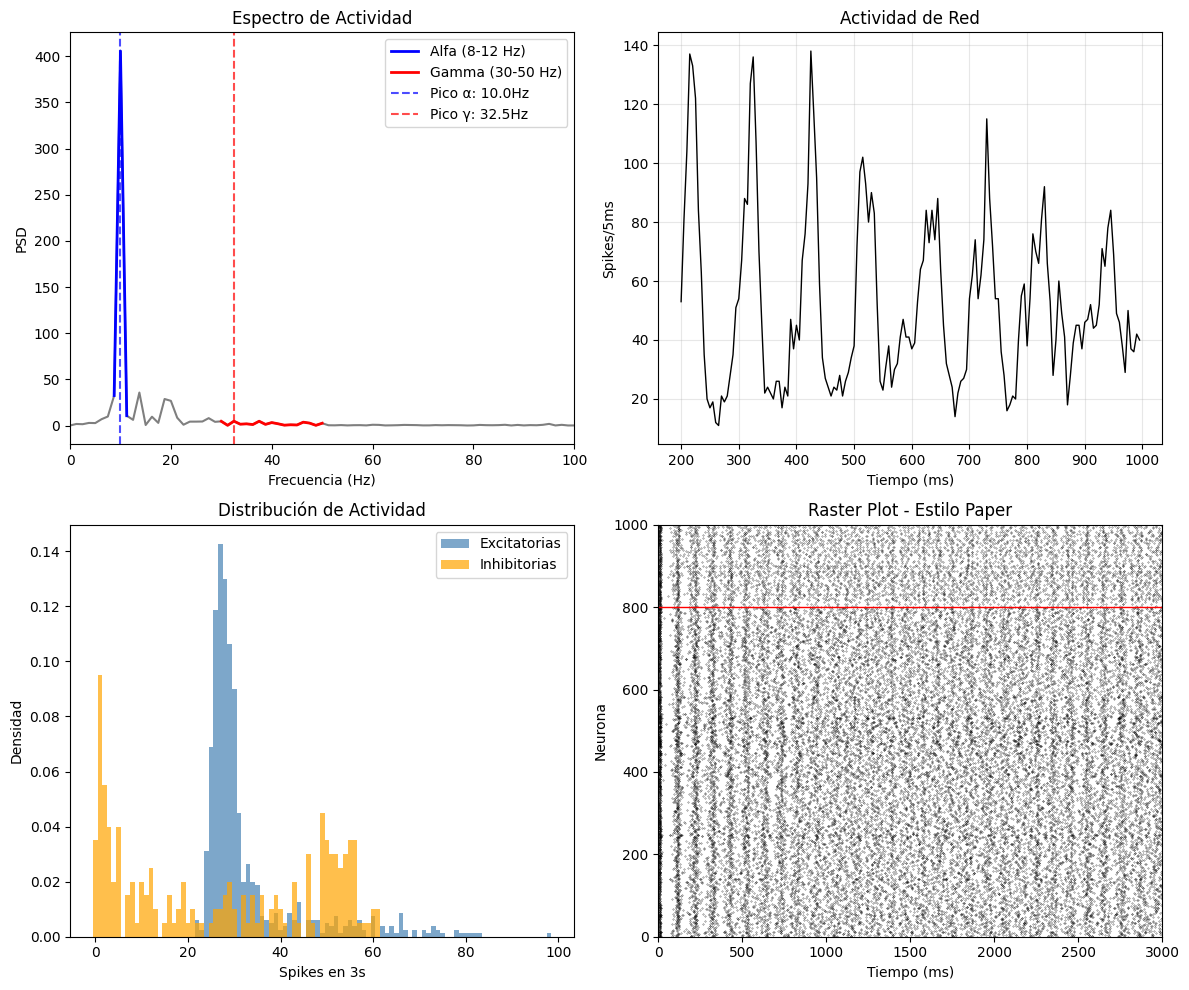

Baseline - Proporción Alfa: 0.6719
Baseline - Proporción Gamma: 0.0525
Baseline - Pico Alfa: 10.0 Hz
Baseline - Pico Gamma: 32.5 Hz


In [5]:
# Ejecutar simulacion
if __name__ == "__main__":
    # Prueba rápida con parámetros base CORREGIDOS
    print("=== PRUEBA CON PARÁMETROS BASE CORREGIDOS ===")
    base_params = {
        'input_strength_exc': 2.0,  # Reducido de 2.0
        'input_strength_inh': 1.0,  # Reducido de 1.0
        'input_rate_exc': 1.5,
        'input_rate_inh': 1.0,
        'k_exc': 2.5,  # Reducido de 2.5
        'k_inh': 5.0,  # Aumentado de 5.0
        'delay_exc': 1.0,
        'delay_inh': 1.0,  # Ligeramente reducido para gamma
        'connectivity': 0.1,
        'ei_connectivity_factor': 1.,  # Más E->I
        'ie_connectivity_factor': 1.,  # Más I->E para control
    }
    
    baseline_results = run_complete_analysis(base_params, duration=3000*ms, plot=True)
    
    if baseline_results is not None:
        print(f"Baseline - Proporción Alfa: {baseline_results['alfa_power']/baseline_results['total_power']:.4f}")
        print(f"Baseline - Proporción Gamma: {baseline_results['gamma_power']/baseline_results['total_power']:.4f}")
        print(f"Baseline - Pico Alfa: {baseline_results['alfa_peak_freq']:.1f} Hz")
        print(f"Baseline - Pico Gamma: {baseline_results['gamma_peak_freq']:.1f} Hz")
    else:
        print("ERROR: La simulación baseline falló")
    
    # Uncomment para ejecutar optimización:
    # best_result = optimize_alfa_gamma(
    #     method='random_search',  # Cambiar por 'differential_evolution' o 'grid_search'
    #     optimization_target='combined',
    #     max_iterations=50,
    #     n_trials=1
    # )

In [6]:
def parameter_sweep_2d(param1_name, param1_range, param2_name, param2_range, 
                       base_params, n_points=10):
    """
    Barrido 2D de parámetros con seguimiento de progreso
    """
    results = np.zeros((n_points, n_points, 4))  # alfa_freq, gamma_freq, alfa_power, gamma_power
    
    param1_values = np.linspace(*param1_range, n_points)
    param2_values = np.linspace(*param2_range, n_points)
    
    print(f"Barriendo {param1_name} vs {param2_name}")
    print(f"Simulaciones totales: {n_points * n_points}")
    
    for i, p1 in enumerate(param1_values):
        for j, p2 in enumerate(param2_values):
            params = base_params.copy()
            params[param1_name] = p1
            params[param2_name] = p2
            
            try:
                sim = run_izhikevich_simulation(params, duration=1000*ms)
                analysis_data = analysis(sim)
                
                if analysis_data and analysis_data['total_power'] > 0:
                    results[i,j,0] = analysis_data['alfa_peak_freq']
                    results[i,j,1] = analysis_data['gamma_peak_freq']  
                    results[i,j,2] = analysis_data['alfa_power']/analysis_data['total_power']
                    results[i,j,3] = analysis_data['gamma_power']/analysis_data['total_power']
                else:
                    results[i,j,:] = np.nan  # Simulación fallida
                    
            except Exception as e:
                print(f"Error en ({p1:.2f}, {p2:.2f}): {e}")
                results[i,j,:] = np.nan
                
        print(f"Completado: {(i+1)*n_points}/{n_points*n_points} ({100*(i+1)/n_points:.0f}%)")
    
    return results, param1_values, param2_values

def plot_sweep_results(results, param1_values, param2_values, param1_name, param2_name):
    """
    Crea heatmaps de los resultados del barrido
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Títulos y etiquetas
    titles = ['Frecuencia Pico Alfa (Hz)', 'Frecuencia Pico Gamma (Hz)', 
              'Proporción Potencia Alfa', 'Proporción Potencia Gamma']
    
    # Crear meshgrid para plots
    X, Y = np.meshgrid(param2_values, param1_values)
    
    for idx, (ax, title) in enumerate(zip(axes.flat, titles)):
        data = results[:,:,idx]
        
        # Manejar NaN values
        if np.all(np.isnan(data)):
            ax.text(0.5, 0.5, 'Sin datos válidos', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=12)
            ax.set_title(title)
            continue
            
        # Crear heatmap
        if idx < 2:  # Frecuencias
            vmin, vmax = np.nanmin(data), np.nanmax(data)
            cmap = 'viridis'
        else:  # Proporciones 
            vmin, vmax = 0, np.nanmax(data)
            cmap = 'plasma'
            
        im = ax.imshow(data, extent=[param2_values[0], param2_values[-1], 
                                    param1_values[0], param1_values[-1]], 
                      aspect='auto', origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        
        # Añadir contornos para mejor visualización
        if not np.all(np.isnan(data)):
            contours = ax.contour(X, Y, data, levels=5, colors='white', alpha=0.3, linewidths=0.5)
            ax.clabel(contours, inline=True, fontsize=8, fmt='%.1f')
        
        ax.set_xlabel(param2_name.replace('_', ' ').title())
        ax.set_ylabel(param1_name.replace('_', ' ').title()) 
        ax.set_title(title)
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        if idx < 2:
            cbar.set_label('Hz')
        else:
            cbar.set_label('Proporción')
    
    plt.tight_layout()
    plt.show()

def plot_regime_map(results, param1_values, param2_values, param1_name, param2_name):
    """
    Mapa de regímenes dominantes (alfa, gamma, mixto, ninguno)
    """
    alfa_prop = results[:,:,2]
    gamma_prop = results[:,:,3]
    
    # Clasificar regímenes
    regime_map = np.zeros_like(alfa_prop, dtype=int)
    
    # 0: Sin actividad, 1: Alfa dominante, 2: Gamma dominante, 3: Mixto
    for i in range(results.shape[0]):
        for j in range(results.shape[1]):
            if np.isnan(alfa_prop[i,j]) or np.isnan(gamma_prop[i,j]):
                regime_map[i,j] = 0  # Sin datos
            elif alfa_prop[i,j] > 0.1 and gamma_prop[i,j] > 0.1:
                if abs(alfa_prop[i,j] - gamma_prop[i,j]) < 0.05:
                    regime_map[i,j] = 3  # Mixto balanceado
                elif alfa_prop[i,j] > gamma_prop[i,j]:
                    regime_map[i,j] = 1  # Alfa dominante
                else:
                    regime_map[i,j] = 2  # Gamma dominante
            elif alfa_prop[i,j] > 0.1:
                regime_map[i,j] = 1  # Solo alfa
            elif gamma_prop[i,j] > 0.1:
                regime_map[i,j] = 2  # Solo gamma
            else:
                regime_map[i,j] = 0  # Sin oscilaciones
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    colors = ['white', 'blue', 'red', 'purple']
    labels = ['Sin oscilaciones', 'Alfa dominante', 'Gamma dominante', 'Mixto']
    
    im = ax.imshow(regime_map, extent=[param2_values[0], param2_values[-1], 
                                     param1_values[0], param1_values[-1]], 
                  aspect='auto', origin='lower', cmap=plt.matplotlib.colors.ListedColormap(colors))
    
    ax.set_xlabel(param2_name.replace('_', ' ').title())
    ax.set_ylabel(param1_name.replace('_', ' ').title())
    ax.set_title('Mapa de Regímenes Oscilatorios')
    
    # Colorbar personalizado
    cbar = plt.colorbar(im, ax=ax, ticks=[0,1,2,3])
    cbar.ax.set_yticklabels(labels)
    
    plt.tight_layout()
    plt.show()

# Ejecutar barrido de delays
if __name__ == "__main__":
    base_params = {
        'input_strength_exc': 2.0,
        'input_strength_inh': 1.0,
        'input_rate_exc': 1.5,
        'input_rate_inh': 1.0,
        'k_exc': 5.0,
        'k_inh': 5.0,
        'delay_exc': 1.0,  # Se variará
        'delay_inh': 1.0,  # Se variará  
        'connectivity': 0.1,
        'ei_connectivity_factor': 1.0,
        'ie_connectivity_factor': 1.0,
    }
    
    # Barrido de delays
    results, param1_vals, param2_vals = parameter_sweep_2d(
        'delay_exc', (0.5, 2.0),
        'delay_inh', (0.2, 2.0), 
        base_params, n_points=12
    )
    
    # Visualizar resultados
    plot_sweep_results(results, param1_vals, param2_vals, 'delay_exc', 'delay_inh')
    plot_regime_map(results, param1_vals, param2_vals, 'delay_exc', 'delay_inh')
    
    # Estadísticas
    print(f"\n=== ESTADÍSTICAS DEL BARRIDO ===")
    print(f"Simulaciones exitosas: {np.sum(~np.isnan(results[:,:,0]))}/{results.shape[0]*results.shape[1]}")
    print(f"Rango frecuencias alfa: {np.nanmin(results[:,:,0]):.1f} - {np.nanmax(results[:,:,0]):.1f} Hz")
    print(f"Rango frecuencias gamma: {np.nanmin(results[:,:,1]):.1f} - {np.nanmax(results[:,:,1]):.1f} Hz")
    print(f"Max proporción alfa: {np.nanmax(results[:,:,2]):.3f}")
    print(f"Max proporción gamma: {np.nanmax(results[:,:,3]):.3f}")

Barriendo delay_exc vs delay_inh
Simulaciones totales: 144
DATOS GENERALES DE LA SIMULACIÓN
Arquitectura:
  Neuronas: 800 exc + 200 inh (ratio 4:1 ✓)
  Conexiones: 100231 totales
  Prob. conexión: 0.100 (esperada: 0.100)

Actividad:
  Freq. excitatorias: 54.3 Hz (paper: ~8Hz)
  Freq. inhibitorias: 63.7 Hz
  Spikes totales: 56226

Comportamiento emergente:
  Índice asincronía: 5.34 (>1 = asíncrono ✓)
  Neuronas activas: 1000/1000 (100.0%)
---------------------------------------------

=== DIAGNÓSTICO DE LA SIMULACIÓN ===
Duración: 1. s
Spikes excitatorios: 43477
Spikes inhibitorios: 12749
Tasa promedio exc: 54.3 Hz/neurona
Tasa promedio inh: 63.7 Hz/neurona
Tasa poblacional media: 45.3 Hz
Proporción Alfa: 0.0605
Proporción Gamma: 0.2884
Pico Alfa: 11.25 Hz
Pico Gamma: 30.00 Hz


KeyboardInterrupt: 

In [ ]:
def objective_function(param_values, param_names, optimization_target='combined'):
    """
    Función objetivo para optimización
    
    param_values: array con valores de parámetros
    param_names: lista con nombres de parámetros
    optimization_target: 'combined', 'alfa_only', 'gamma_only'
    """
    # Convertir array a dict
    params = dict(zip(param_names, param_values))
    
    try:
        # Ejecutar simulación
        results = run_izhikevich_simulation(params, duration=3000*ms, plot=False)
        
        if results is None:  # Error en la simulación
            return 1e6
        
        # Verificar que la simulación no colapse - CRITERIOS MEJORADOS
        spike_rate_exc = results['spike_count_exc'] / (800 * 3.0)  # Hz por neurona
        spike_rate_inh = results['spike_count_inh'] / (200 * 3.0)
        
        # Rangos fisiológicos más estrictos
        if spike_rate_exc < 1.0 or spike_rate_exc > 50.0:  # Muy poca o mucha actividad exc
            return 1e6
        if spike_rate_inh < 5.0 or spike_rate_inh > 100.0:  # Muy poca o mucha actividad inh
            return 1e6
        if np.mean(results['pop_rate']) > 200:  # Tasa poblacional demasiado alta
            return 1e6
            
        alfa_proportion = results['alfa_power'] / results['total_power']
        gamma_proportion = results['gamma_power'] / results['total_power']
        
        # Penalizar si no hay picos detectables
        if results['alfa_peak_power'] < 1e-6 and optimization_target in ['combined', 'alfa_only']:
            return 1e6
        if results['gamma_peak_power'] < 1e-6 and optimization_target in ['combined', 'gamma_only']:
            return 1e6
        
        if optimization_target == 'combined':
            # Maximizar alfa + gamma con peso balanceado
            combined_score = alfa_proportion + 0.5 * gamma_proportion  # Alfa más importante
            objective = 1.0 - combined_score
        elif optimization_target == 'alfa_only':
            objective = 1.0 - alfa_proportion
        elif optimization_target == 'gamma_only':
            objective = 1.0 - gamma_proportion
        elif optimization_target == 'ratio':
            # Mantener ratio específico alfa/gamma
            target_ratio = 2.5  # Alfa debería ser ~2.5x más fuerte que gamma
            actual_ratio = alfa_proportion / (gamma_proportion + 1e-6)
            objective = abs(actual_ratio - target_ratio) + (1.0 - alfa_proportion - gamma_proportion)
            
        return objective
        
    except Exception as e:
        print(f"Error en simulación: {e}")
        return 1e6
    

def optimize_alfa_gamma(method='differential_evolution', optimization_target='combined', 
                       max_iterations=50, n_trials=1):
    """
    Optimiza parámetros para maximizar picos alfa-gamma
    
    method: 'differential_evolution', 'grid_search', 'random_search'
    optimization_target: 'combined', 'alfa_only', 'gamma_only', 'ratio'
    max_iterations: número máximo de evaluaciones
    n_trials: número de pruebas independientes
    """
    
    # Definir parámetros a optimizar y sus rangos
    param_config = {
        'input_strength_exc': (1.0, 4.0),     # Fuerza input excitatorio
        'input_strength_inh': (0.5, 2.5),     # Fuerza input inhibitorio  
        'input_rate_exc': (0.5, 3.0),         # Frecuencia input excitatorio
        'input_rate_inh': (0.5, 2.5),         # Frecuencia input inhibitorio
        'k_exc': (1.5, 4.0),                  # Constante acoplamiento excitatorio
        'k_inh': (3.0, 8.0),                  # Constante acoplamiento inhibitorio
        'delay_exc': (0.5, 3.0),              # Delay sinapsis excitatorias (ms)
        'delay_inh': (0.2, 2.0),              # Delay sinapsis inhibitorias (ms)
        'connectivity': (0.05, 0.2),          # Probabilidad conectividad
        'ei_connectivity_factor': (0.8, 2.0), # Factor conectividad E->I
        'ie_connectivity_factor': (0.8, 2.5), # Factor conectividad I->E
    }
    
    param_names = list(param_config.keys())
    bounds = list(param_config.values())
    
    print(f"=== OPTIMIZACIÓN ALFA-GAMMA ===")
    print(f"Método: {method}")
    print(f"Objetivo: {optimization_target}")
    print(f"Parámetros a optimizar: {len(param_names)}")
    print(f"Rango de evaluaciones: {max_iterations}")
    print()
    
    best_results = []
    
    for trial in range(n_trials):
        print(f"--- Prueba {trial + 1}/{n_trials} ---")
        start_time = time.time()
        
        if method == 'differential_evolution':
            result = differential_evolution(
                objective_function,
                bounds,
                args=(param_names, optimization_target),
                seed=42 + trial,
                maxiter=max_iterations//10,  # DE usa generaciones
                popsize=10,
                atol=1e-6,
                disp=True
            )
            best_params = dict(zip(param_names, result.x))
            best_score = result.fun
            
        elif method == 'random_search':
            best_score = float('inf')
            best_params = {}
            
            for i in range(max_iterations):
                # Generar parámetros aleatorios
                random_params = {}
                for param, (min_val, max_val) in param_config.items():
                    random_params[param] = np.random.uniform(min_val, max_val)
                
                score = objective_function(
                    list(random_params.values()), 
                    param_names, 
                    optimization_target
                )
                
                if score < best_score:
                    best_score = score
                    best_params = random_params.copy()
                    print(f"Iteración {i+1}: Nuevo mejor = {1-best_score:.4f}")
        
        elif method == 'grid_search':
            # Grid search simplificado (solo algunos parámetros clave)
            key_params = ['k_exc', 'k_inh', 'input_strength_exc', 'delay_inh']
            n_points = int(max_iterations**(1/len(key_params)))  # n^4 = max_iterations
            
            best_score = float('inf')
            best_params = {}
            
            # Usar valores por defecto para parámetros no optimizados
            default_params = {k: (v[0] + v[1])/2 for k, v in param_config.items()}
            
            iteration = 0
            for k_exc in np.linspace(*param_config['k_exc'], n_points):
                for k_inh in np.linspace(*param_config['k_inh'], n_points):
                    for input_exc in np.linspace(*param_config['input_strength_exc'], n_points):
                        for delay_inh in np.linspace(*param_config['delay_inh'], n_points):
                            test_params = default_params.copy()
                            test_params.update({
                                'k_exc': k_exc,
                                'k_inh': k_inh, 
                                'input_strength_exc': input_exc,
                                'delay_inh': delay_inh
                            })
                            
                            score = objective_function(
                                list(test_params.values()),
                                param_names,
                                optimization_target
                            )
                            
                            if score < best_score:
                                best_score = score
                                best_params = test_params.copy()
                                print(f"Grid {iteration+1}: Nuevo mejor = {1-best_score:.4f}")
                            
                            iteration += 1
                            if iteration >= max_iterations:
                                break
                        if iteration >= max_iterations:
                            break
                    if iteration >= max_iterations:
                        break
                if iteration >= max_iterations:
                    break
        
        elapsed = time.time() - start_time
        print(f"Tiempo: {elapsed:.1f}s")
        print(f"Mejor score: {1-best_score:.4f}")
        print()
        
        # Evaluar mejor resultado
        final_results = run_izhikevich_simulation(best_params, duration=3000*ms, plot=True)
        
        best_results.append({
            'params': best_params,
            'score': best_score,
            'results': final_results,
            'trial': trial
        })
    
    # Mostrar mejor resultado global
    global_best = min(best_results, key=lambda x: x['score'])
    print("=== MEJOR RESULTADO GLOBAL ===")
    print(f"Score: {1-global_best['score']:.4f}")
    print("Parámetros óptimos:")
    for param, value in global_best['params'].items():
        print(f"  {param}: {value:.3f}")
    
    results = global_best['results']
    print(f"\nMétricas espectrales:")
    print(f"  Proporción Alfa: {results['alfa_power']/results['total_power']:.3f}")
    print(f"  Proporción Gamma: {results['gamma_power']/results['total_power']:.3f}")
    print(f"  Pico Alfa: {results['alfa_peak_freq']:.1f} Hz")
    print(f"  Pico Gamma: {results['gamma_peak_freq']:.1f} Hz")
    
    return global_best